In [319]:
import tensorflow as tf
print(tf.__version__)
import torchaudio
import sys,os
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import librosa
import librosa.display
import re

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# models
from sklearn import linear_model, naive_bayes, neighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# stat libraries
from scipy import stats

# Libraries for the evaluation
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline

2.0.0-beta1


# -  Data Loading & Feature Extraction

In [320]:
sample_rate = 16000
def extract_features(audio):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
 
    return mfccs   # it returns a np.array with size (40,'n') where n is the number of audio frames.

In [321]:
# there are 2703 audio files (ext: .flac)

root = "LibriSpeech/dev-clean/"
df = pd.DataFrame(columns=['speaker_id', 'features'])              

i = 0
max_pad_len = 1021

# loading the features in the first dataframe
for path, subdirs, files in os.walk(root):
    for name in files:
        speaker_id = path.split('/')[2]
        if name.endswith(".flac"):
            sound, sample_rate = librosa.load(os.path.join(path, name), sr=16000)
            data = extract_features(sound)
            
            # zero-pad the mfccs features in order to have all compatible shapes for input of the CNN.
            # max_pad_len is the biggest number of audio frames
            # obtained by extracting features (mfccs) from all the audio files.
            pad_width = max_pad_len - data.shape[1]
            data = np.pad(data, pad_width=((0,0), (0, pad_width)), mode='constant')
            df.loc[i] = [speaker_id] + [data]
            i += 1
            
# loading the labels in the second dataframe
root = "LibriSpeech/"
labels = pd.DataFrame(columns=['speaker_id', 'gender'])

f = open("LibriSpeech/SPEAKERS.txt", "r", encoding="UTF8").readlines()
i = 0
for idx, line in enumerate(f):
    if idx > 11:
        parsed = re.split('\s+',line)
        if parsed[4] == 'dev-clean':
            labels.loc[i] = parsed[0], parsed[2] # speaker_id and label (M/F)
            i += 1   

dataset = pd.merge(df, labels, on='speaker_id')  # merging the two dataframes.

# REPLACE CATEGORICAL VALUES INTO NUMERIC VALUES
dataset["gender"].replace({"M": 1, "F": 0}, inplace=True)
dataset.head(10)

,speaker_id,features,gender
0,2412,"[[-635.7891, -635.67395, -635.6435, -635.66394...",0
1,2412,"[[-637.5279, -637.41113, -637.30176, -637.3078...",0
2,2412,"[[-664.281, -664.2972, -662.12994, -660.398, -...",0
3,2412,"[[-649.1268, -648.9596, -648.921, -648.9577, -...",0
4,2412,"[[-668.34106, -667.13873, -668.30634, -670.508...",0
5,2412,"[[-611.3594, -611.3433, -611.6644, -611.59955,...",0
6,2412,"[[-697.93866, -697.8957, -697.8562, -697.87, -...",0
7,2412,"[[-601.1766, -601.9571, -602.7137, -604.12354,...",0
8,2412,"[[-675.662, -676.1053, -677.2934, -678.08, -67...",0
9,2412,"[[-681.15454, -677.1896, -675.19855, -673.7333...",0


There are 20 males speakers (1374 audio files) and 20 female speakers (1329 audio files): the dataset is almost perfectly balanced and this means that using Accuracy as evaluation metric should be a reliable estimator of the models performances.

In [322]:
dataset['gender'].value_counts()

0    1374
1    1329
Name: gender, dtype: int64

# -  Train / Test split

I need to partition test and train keeping into account:

- Maintain the balance between F and M (= STRATIFIED SAMPLING)
- Speakers in train have to be completely different from the ones in test (= INDEPENDENT SAMPLES/SPEAKERS).
So if speaker called 'Marc' is linked to 3 audio files, all of these audio will be in the test OR in the train, but not in both.

To the best of my knowledge, I can't obtain BOTH with the built-in function of sklearn (train-test split).
Here is the custom function I implemented:

In [323]:
train_test_ratio = 0.80
n_sounds = 2703

def split_train_test(train_test_ratio, n_sounds):
    
    train = pd.DataFrame(columns=['speaker_id', 'features' , 'gender'])
    test = pd.DataFrame(columns=['speaker_id', 'features', 'gender'])
    
    train_elems = int(np.floor(n_sounds*train_test_ratio))
    test_elems = n_sounds - train_elems
    
    print("Splitting ratio: ",train_test_ratio)
    print("Expected audio in the train: ", train_elems)
    print("Expected audio in the test: ", test_elems)
    print("Total audios: ", n_sounds)
    
    """
    EXPLANATION:
    so, there are 20 males speakers (1374 audio files) and 20 female speakers (1329 audio files).
    
    first run:
        - until is not reached the 0.8 (=split ratio) * number of audio of males...
        - ...keep adding all the audio of each MALE speaker (almost 16 speakers)
        - Then, adds the audio of the remaining (4) speakers to the test
        
    second run:
        - until the train set doesn't have enough audio (so, 0.8 * total number of audio)...
        - ...keep adding all the audio of each FEMALE speaker
        - Then, adds the audio of the remaining speakers to the test.
        
    
    Now train and test have a balanced number of male and female speakers... and independent samples.
    """

    male_train = int(np.floor(dataset['gender'].value_counts()[0]* train_test_ratio))
    male_test = int(np.ceil(dataset['gender'].value_counts()[0]* (1-train_test_ratio)))
    train_sizes = [male_train, train_elems]
    test_sizes = [male_test + male_train, n_sounds]
    
    for gender in range(2):  
        if gender == 0:
            gender_set = dataset[dataset["gender"] == gender]   # MALES
        elif gender == 1:
            gender_set = dataset[dataset["gender"] == gender]   # FEMALES

        ordered_gender_set = gender_set['speaker_id'].value_counts()
        i = 0
        while (train.shape[0] < train_sizes[gender]):
            train = train.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1
        while (test.shape[0] + train.shape[0] != test_sizes[gender]): 
            test = test.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1
            
    # Since we are inserting a speaker (and all its related audio files) per time, 
    # the splitting ratio might slightly differ:
    print("\nActual splitting ratio: {:.3f}".format(train.shape[0]/n_sounds))
    print("Actual audio in the train: ", train.shape[0])
    print("Actual audio in the test: ", test.shape[0])

    print("\nMales in the train: ", train['gender'].value_counts()[0])
    print("Males in the test: ", test['gender'].value_counts()[0])
    print("Females in the train: ", train['gender'].value_counts()[1])
    print("Females in the test: ", test['gender'].value_counts()[1])

    return train, test
   
train, test = split_train_test(train_test_ratio, n_sounds)

Splitting ratio:  0.8
Expected audio in the train:  2162
Expected audio in the test:  541
Total audios:  2703

Actual splitting ratio: 0.805
Actual audio in the train:  2176
Actual audio in the test:  527

Males in the train:  1124
Males in the test:  250
Females in the train:  1052
Females in the test:  277


# ML Algorithms

In [324]:
# features are 3d. I'll average along the axis of n-frame audio so that, per each audio file, I'll have
# 40 MFCCs (instead of 40xn). 

X_train = np.mean(np.array(train.features.tolist()), axis = 2)
X_test = np.mean(np.array(test.features.tolist()), axis = 2)
y_train = np.array(train.gender.tolist())
y_test = np.array(test.gender.tolist())

le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train)) 
yy_test = to_categorical(le.fit_transform(y_test)) 

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2176, 40), (2176,), (527, 40), (527,))

## KNN

In [325]:
knn = neighbors.KNeighborsClassifier(18, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_knn = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_knn)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[190  60]
 [ 60 217]]

Accuracy:  0.7722960151802657

Precision:  0.7833935018050542

Recall:  0.7833935018050542


## Naive Bayes

In [326]:
nb = naive_bayes.GaussianNB();
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_nb = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_nb)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[231  19]
 [ 76 201]]

Accuracy:  0.8197343453510436

Precision:  0.9136363636363637

Recall:  0.7256317689530686


## Support Vector Machine

In [327]:
from sklearn import svm
svc = svm.SVC(kernel='poly', gamma='auto')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_svm = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_svm)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[213  37]
 [ 52 225]]

Accuracy:  0.8311195445920304

Precision:  0.8587786259541985

Recall:  0.8122743682310469


## Perceptron

The Perceptron required shuffling of the training to make the gradient descent work in the proper way.

For what concerns the other algorithms, instead, shuffling didn't bring any advantage/difference in the performances.

In [328]:
from sklearn.linear_model import Perceptron

knn = Perceptron(shuffle=True) # training data are shuffled at each epoch.
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_perceptron = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_perceptron)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[213  37]
 [ 48 229]]

Accuracy:  0.8387096774193549

Precision:  0.8609022556390977

Recall:  0.8267148014440433


## Logistic Regression

In [182]:
log = linear_model.LogisticRegression(C=1e5, solver='saga', max_iter=100, verbose=0)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_log = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_log)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[197  53]
 [ 30 247]]

Accuracy:  0.8425047438330171

Precision:  0.8233333333333334

Recall:  0.8916967509025271


/Users/emanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Neural Network

In [315]:
mlp = MLPClassifier(random_state=1, max_iter=500)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_mlp = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_mlp)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[233  17]
 [ 56 221]]

Accuracy:  0.8614800759013282

Precision:  0.9285714285714286

Recall:  0.7978339350180506


In [314]:
def plot_history(history, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

## Convolutional Neural Network

In [86]:
X_train = np.array(train.features.tolist())
X_test = np.array(test.features.tolist())
y_train = np.array(train.gender.tolist())
y_test = np.array(test.gender.tolist())

le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train)) 
yy_test = to_categorical(le.fit_transform(y_test))

In [102]:
num_rows = 40
num_columns = 1021
num_channels = 1
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

print(X_train.shape, X_test.shape)

num_labels = yy_train.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

(2176, 40, 1021, 1) (527, 40, 1021, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 39, 1020, 16)      80        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 19, 510, 16)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 19, 510, 16)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 18, 509, 32)       2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 9, 254, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 9, 254, 32)        0         
_________________________________________________________________
conv2d_15 (Conv

In [103]:
score = model.evaluate(X_test, yy_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 59.7723%


In [104]:
num_epochs = 20
num_batch_size = 32

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# In min mode, training will stop when the val_loss has stopped decreasing
# Patience is the number of epochs without improvement after which training will be stopped.

history = model.fit(X_train, yy_train, epochs=num_epochs, batch_size=num_batch_size, validation_data=(X_test, yy_test), callbacks=[es])

Train on 2176 samples, validate on 527 samples
Epoch 1/20
2176/2176 [==============================] - 49s 23ms/step - loss: 0.7174 - accuracy: 0.7017 - val_loss: 0.2707 - val_accuracy: 0.8843
Epoch 2/20
2176/2176 [==============================] - 43s 20ms/step - loss: 0.3490 - accuracy: 0.8695 - val_loss: 0.2550 - val_accuracy: 0.9051
Epoch 3/20
2176/2176 [==============================] - 43s 20ms/step - loss: 0.3179 - accuracy: 0.8842 - val_loss: 0.2357 - val_accuracy: 0.9051
Epoch 4/20
2176/2176 [==============================] - 44s 20ms/step - loss: 0.2960 - accuracy: 0.8980 - val_loss: 0.2275 - val_accuracy: 0.9165
Epoch 5/20
2176/2176 [==============================] - 44s 20ms/step - loss: 0.2584 - accuracy: 0.9076 - val_loss: 0.1896 - val_accuracy: 0.9374
Epoch 6/20
2176/2176 [==============================] - 43s 20ms/step - loss: 0.2294 - accuracy: 0.9228 - val_loss: 0.2120 - val_accuracy: 0.9203
Epoch 7/20
2176/2176 [==============================] - 50s 23ms/step - loss:

In [105]:
score = model.evaluate(X_test, yy_test, verbose=0)
accuracy_cnn = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)
print("Post-training accuracy: %.4f%%" % accuracy_cnn)

Pre-training accuracy: 59.7723%
Post-training accuracy: 92.5996%


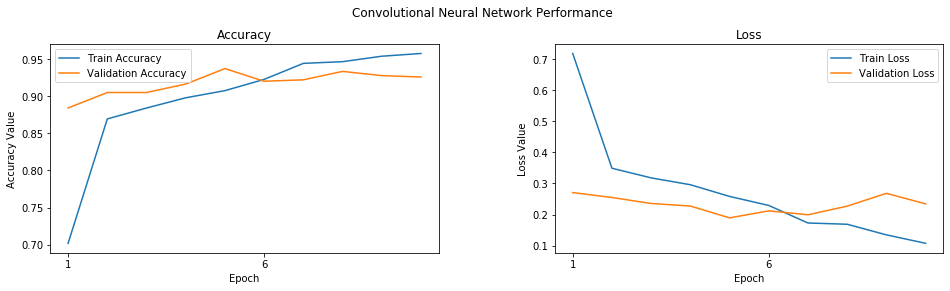

In [108]:
title='Convolutional Neural Network Performance'
plot_history(history, title)

# Final results and Considerations

In [329]:
print("\nK-Nearest Neighbors accuracy: %.4f%%" % (accuracy_knn*100))
print("\nNaive-Bayes accuracy: %.4f%%" % (accuracy_nb*100))
print("\nSupport Vector Machine accuracy: %.4f%%" % (accuracy_svm*100))
print("\nPerceptron: %.4f%%" % (accuracy_perceptron*100))
print("\nLogistic Regression accuracy: %.4f%%" % (accuracy_log*100))
print("\nMulti-layer Perceptron accuracy: %.4f%%" % (accuracy_mlp*100))
print("\nConvolutional Neural Network accuracy: %.4f%%" % accuracy_cnn)


K-Nearest Neighbors accuracy: 77.2296%

Naive-Bayes accuracy: 81.9734%

Support Vector Machine accuracy: 83.1120%

Perceptron: 83.8710%

Logistic Regression accuracy: 84.2505%

Multi-layer Perceptron accuracy: 86.1480%

Convolutional Neural Network accuracy: 92.5996%


**General Considerations:**

As expected, the best model is the CNN, able to automatically extract the most relevant features from the 3-dimensional MFCCs given. My idea about this deep neural network is that, spending more time in the processes of selecting the right layers and tweaking the hyperparameters would lead to even better results.
Also, using a bigger training set would drastically boost the performances.
It's interesting to observe that the test_accuracy is higher than the train_accuracy even in the first epochs of training: this might be due to the dropout layers, where, in the training, some features are set to zero, while, in the test all features are used. This probably is leading to more robust results in the testing of the model.

The other ML models are outperformed by the CNN but still able to obtain, in my opinion, satisfiable results.
Furthermore, the scores are very far from the random guess (accuracy 50%) obtained by a model not trained.

The SVM, Perceptron, LogReg and MLP reach performances very similar. MLP seems to outperform the other models, BUT to determine which performs better I would check also other metrics (precisio, recall, AUC score, etc), use crossvalidation (for more reliable results) and perform statistical tests.

Finally, I was expecting that KNN would have not performed well, since this algorithm suffers of the well-known 'curse of dimensionality': that is the problem of poor performances when the samples of the dataset belong to an high-dimensional feature space (40 MFCCs features !). 
It would be interesting to apply first PCA to the MFCCs and observe if reducing the number of dimensions is going to improve the results.

## Possible improvements

These are some future possible improvements / optimizations I would perform to improve the results obtained in these notebook.

- In a bigger project, I would put all the utils functions in a separate .py file, in order to have more order in the main notebooks.

- To simplify everything, I didn't use a validation set. But in every big project/company project, to have realiable results, it's good practice to split in train, test and validation.

- To obtain more accurate results, use crossvalidation (and statistical tests) to select the right model.

- Train a more complex CNN and for longer period of time.

- Of course, before deployment, what I would do is to re-train all the models with the full dataset (train + test) in order to have best performances possible: the bigger the dataset, the more boosted are the performances.
  
- Evaluate all these results looking at more metrics: precision, recall, AUC score, etc.

- I used just a basic CNN. I believe performances would increase even more using a network already trained (such as VGG-19 and apply transfer learning).

- Instead of MFCCS, I could train the CNN using two other types of features (they may lead to even better results): 
    - Audio Signals (Amplitude v/s Time)
    - Spectograms (Frequencies v/s Time)

See below two examples of Audio Signals and Spectograms: potential input for a CNN.

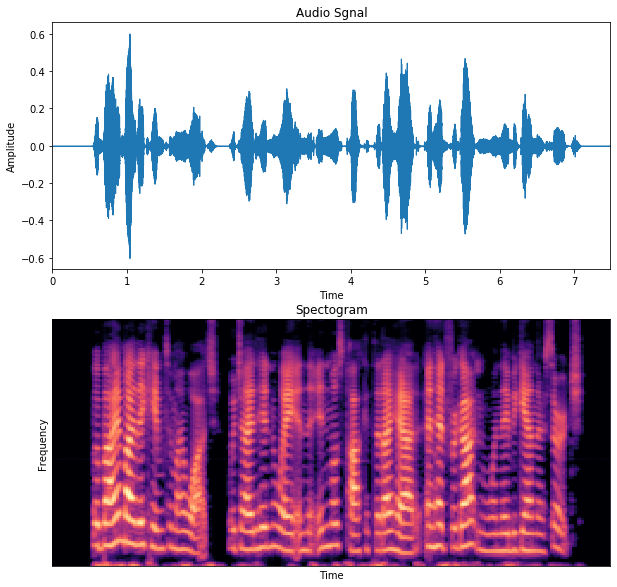

In [216]:
path = "LibriSpeech/dev-clean/2412/153954/2412-153954-0019.flac"
sound, sample_rate = librosa.load(path, sr=16000)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
librosa.display.waveplot(sound, sr= sample_rate)
plt.title('Audio Sgnal')
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
spectogram = librosa.feature.melspectrogram(sound, sr=sample_rate)
log_spectogram = librosa.power_to_db(spectogram, ref=np.max)
librosa.display.specshow(log_spectogram)
plt.title('Spectogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()